based on 

https://hsf-training.github.io/hsf-training-scikit-hep-webpage/

https://cms-opendata-workshop.github.io/workshop2022-lesson-ttbarljetsanalysis/01-introduction/

https://github.com/iris-hep/analysis-grand-challenge/blob/main/workshops/agctools2022/coffea/coffea_analysis.ipynb

In [1]:
import hist
import warnings
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

warnings.filterwarnings("ignore", message="Missing cross-reference index ")

def print_ak_array(array):
    for i in array:
        print(i)

## **Physics objects**

In the previous lesson we saw there exist schemas for some standard file formats, most prominently *NanoAOD*. The first benefit of instating a schema is a standardization of our fields. There are also other benefits to this structure: as we now have a collection object (`events.muon`), there is a natural place to impose physics methods. 

[Vector](https://vector.readthedocs.io/en/latest/) is a Python library for 2D, 3D, and Lorentz vectors, especially arrays of vectors, to solve common physics problems in a NumPy-like way.

The allowed keyword arguments for 2D vectors are:

* `x` and `y` for Cartesian azimuthal coordinates,
* `px` and `py` for momentum,
* `rho` and `phi` for polar azimuthal coordinates,
* `pt` and `phi` for momentum.

For 3D vectors, you need the above and:

* `z` for the Cartesian longitudinal coordinate,
* `pz` for momentum,
* `theta` for the spherical polar angle (from 0 to $\phi$, inclusive),
* `eta` for pseudorapidity.

For 4D vectors, you need the above and:

* `t` for the Cartesian temporal coordinate,
* `tau` for the “proper time” (temporal coordinate in the vector’s rest coordinate system),
* `E` or `energy` to get four-momentum,
* `M` or `mass` to get four-momentum.

The `vector.Array` function behaves exactly like the `ak.Array` constructor, except that it makes arrays of vectors:

In [2]:
import vector

muon_4vector = vector.Array(
    [{"pt": 12.8, "eta": -0.623, "phi": 0.647, "M": 0.106}]
)

**Vector properties**

Any geometrical coordinate can be computed from vectors in any coordinate system; they’ll be provided or computed as needed.

In [3]:
# rho from (rho, phi, eta, t) cylindrical coordinates
muon_4vector.rho

<Array [12.8] type='1 * float64'>

In [4]:
# (x, y, z) from (x, y, z, t) cartesian coordinates
muon_4vector.x, muon_4vector.y, muon_4vector.z

(<Array [10.2] type='1 * float64'>,
 <Array [7.72] type='1 * float64'>,
 <Array [-8.5] type='1 * float64'>)

Some properties are not coordinates, but derived from them

In [5]:
# muon energy from (pt, eta, phi, E)
muon_4vector.E

<Array [15.4] type='1 * float64'>

**Vector methods**

Vector methods require arguments (in parentheses), which may be scalars or other vectors, depending on the calculation.

For example, in many contexts we will be interested in the angular distances between two objects:

In [6]:
mu2_4vector = vector.Array(
    [{"pt": 6.99, "eta": 2.08, "phi": -0.0908, "E": 0.106}]
)

$\Delta\phi(\text{obj}_1, \text{obj}_2)$

In [7]:
muon_4vector.deltaphi(mu2_4vector)

<Array [0.738] type='1 * float64'>

$\Delta R (\text{obj}_1, \text{obj}_2)= \sqrt{\Delta\phi(\text{obj}_1, \text{obj}_2)^2 - \Delta\eta(\text{obj}_1, \text{obj}_2)^2}$

In [8]:
muon_4vector.deltaR(mu2_4vector)

<Array [2.8] type='1 * float64'>

The NanoAOD schema incorporates this vector behavior in the physical objects. This makes mathematical operations on our muons well-defined:

In [9]:
# file name
fname = "root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema, entry_stop=10_000).events()

mu1 = ak.firsts(events.Muon)
mu2 = ak.firsts(ak.pad_none(events.Muon, 2)[:, 1:])

In [10]:
mu1.delta_phi(mu2)

<Array [None, None, -0.0505, ... None, None] type='10000 * ?float32'>

In [11]:
mu1.delta_r(mu2)

<Array [None, None, 0.151, ... None, None] type='10000 * ?float32'>

### **Analysis: Plotting a $Z$-Peak**

With an understanding of basic columnar analysis and our data in the proper format, we are finally ready to turn our attention to our analysis. We want to plot the $Z$-peak. This involves plotting the pair-mass of leptons which have the same flavor (ee or mumu) and opposite sign

In [12]:
# select good muons
good_muons = (
    (events.Muon.pt >= 35)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.tightId)
    & (events.Muon.pfRelIso04_all < 0.15)
)
muons = events.Muon[good_muons]

In [13]:
# we want events with two muons
two_muons_cut = ak.num(muons) == 2

In [14]:
# we want events with opposite charge muons
opposite_charge_muons_cut = ak.sum(muons.charge, axis=1) == 0

In [15]:
# select dimuons 
dimuons = muons[(two_muons_cut) & (opposite_charge_muons_cut)]

Now, we can use the vector behavior of the muons to compute the invariant mass:

In [16]:
# compute invariant mass
dimuon_mass = (dimuons[:, 0] + dimuons[:, 1]).mass

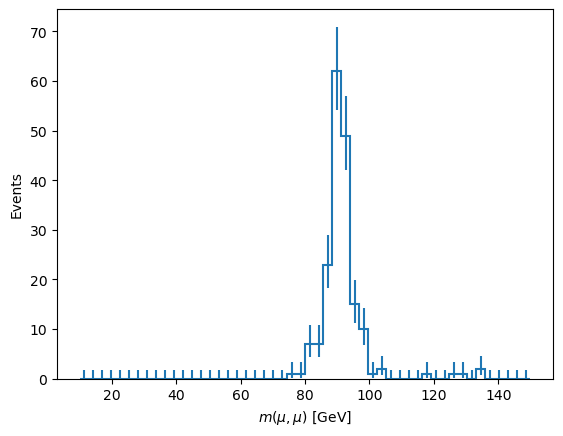

In [17]:
# define and fill the dimuon mass histogram
dimuon_mass_axis = hist.axis.Regular(
    bins=50, start=10, stop=150, name="dimuon_mass", label="$m(\mu, \mu)$ [GeV]"
)
dimuon_mass_histogram = hist.Hist(dimuon_mass_axis)
dimuon_mass_histogram.fill(dimuon_mass=dimuon_mass).plot1d()
plt.ylabel("Events");

**Quiz 1:** 

* Select the transverse missing energy and the leading muons and jets
* Compute the lepton-Jet-MET total transverse mass

$$m_T^{tot}=\sqrt{(p_T^{\mu} + p_T^{jet} + p_T^{miss})² - (\mathbf{p_T^{\mu}} + \mathbf{p_T^{jet}} + \mathbf{p_T^{miss}})²}$$

In [20]:
# select objects
leading_muons = ak.firsts(events.Muon)
leading_jets = ak.firsts(events.Jet)
met = events.MET

# compute total transverse mass
np.sqrt(
    (leading_muons.pt + leading_jets.pt + met.pt) ** 2
    - (leading_muons + leading_jets + met).pt ** 2
)

<Array [98.9, 59, 120, ... 34.4, None, None] type='10000 * ?float32'>

## **Columnar Analysis with Coffea**

The traditional way of analyzing data in HEP involves the event loop. In this paradigm, we would write an explicit loop to go through every event (and through every field of an event that we wish to make a cut on). This method of analysis is rather bulky in comparison to the columnar approach, which (ideally) has no explicit loops at all! Instead, the fields of our data are treated as arrays and analysis is done by way of numpy-like array operations.

![](https://i.imgur.com/LKcMTG0.png)

**What is Coffea?**

Awkward arrays let us access data in a columnar fashion, but that's just the first part of doing an analysis. [Coffea](https://coffeateam.github.io/coffea/) builds upon this foundation with a variety of features that better enable us to do our analyses. These features include:

* **Hists** give us ROOT-like histograms. Actually, this is now a standalone package, but it has been heavily influenced by the (old) coffea hist subpackage, and it's a core component of the coffea ecosystem.

* **NanoEvents** allows us to apply a schema to our awkward array. This schema imposes behavior that we would not have in a simple awkward array, but which makes our (HEP) lives much easier. On one hand, it can serve to better organize our data by providing a structure for naming, nesting, and cross-referencing fields; on the other, it allows us to add physics object methods (e.g., for LorentzVectors).

* **Processors** are coffea's way of encapsulating an analysis in a way that is deployment-neutral. Once you have a Coffea analysis, you can throw it into a processor and use any of a variety of executors (e.g. Dask, Parsl, Spark) to chunk it up and run it across distributed workers. This makes scale-out simple and dynamic for users.

* **Lookup tools** are available in Coffea for any corrections that need to be made to physics data. These tools read a variety of correction file formats and turn them into lookup tables.

In summary, coffea's features enter the analysis pipeline at every step. They improve the usability of our input (NanoEvents), enable us to map it to a histogram output (Hists), and allow us tools for scaling and deployment (Processors).

### **Processors: Deploying at Scale**

Now that we have an analysis, we would naturally like to scale it up to a far larger dataset in any practical scenario. More data means more processing time. We try to amend this fact by making use of parallel processing and distributed computing resources, which coffea can be deployed on rather naturally. Importantly, the details of our analysis are entirely independent of our deployment.

To expand our analysis, we will use coffea Processors. Processors are coffea’s way of encapsulating an analysis in a way that is deployment-neutral. Once you have a Coffea analysis, you can throw it into a processor and use any of a variety of executors (e.g. Dask, Parsl, Spark) to chunk it up and run it across distributed workers. This makes scale-out simple and dynamic for users.

Coffea analyses are written in a **Processor** class:

* **__init__**: Define an accumulator object (histogram, dictionary, DataFrame or array) that will be fill later. 
* **process**: Implement the analysis (observables, regions, corrections, etc) and fill the accumulator object.
* **postprocess**: Manipulate the accumulator object.

In [21]:
import copy
from coffea import processor

class ExampleProcessor(processor.ProcessorABC):
    
    def __init__(self):
        # define accumulator object 
        jet_pt_axis = hist.axis.Regular(
            bins=50, start=20, stop=1000, name="jet_pt", label="Jet $p_T$ [GeV]"
        )
        self.output = hist.Hist(jet_pt_axis)
        
    
    def process(self, events):
        # create copies of histogram objects
        output = copy.deepcopy(self.output)
        
        # select good jets
        jets = events.Jet[events.Jet.pt > 20]

        # get leading jet pt
        leading_jet_pt = ak.firsts(jets).pt
        
        # fill output histogram
        output.fill(jet_pt=ak.fill_none(leading_jet_pt, 0))
        
        return output

    def postprocess(self, accumulator):
        return accumulator

The `Processor` class gets deployed on an **executor**, which chunks up input data and feeds it in.

Currently, two local executors exist: 
* `iterative_executor`: The iterative executor simply processes each chunk of an input dataset in turn, using the current python thread.
* `futures_executor`: It employs python multiprocessing to spawn multiple python processes that process chunks in parallel on the machine

Currently, coffea supports four types of distributed executors:

* the parsl distributed executor, accessed via `parsl_executor`,

* the dask distributed executor, accessed via `dask_executor`,

* the Apache Spark distributed executor, accessed via `run_spark_job`,

* and the Work Queue Executor distributed executor, accessed via `work_queue_executor`.

These executors use their respective underlying libraries to distribute processing tasks over multiple machines.

Thus, we have a pipeline: our input data is chunked, sent off to different workers which each execute the processor on their chunk, and then collected and converged once all workers finish processing.

![](https://i.imgur.com/nCxLquc.png)

In [22]:
# define fileset (list of filenames in fileset must be a list or a dict)
fname = "root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"
fileset = {"dataset": [fname]}

# run a processor using some executor
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=ExampleProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": processor.NanoAODSchema, 
        "workers": 4
    }
)

Output()

Output()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fa58bd9cc70>, errorbar=None, legend_artist=None)]

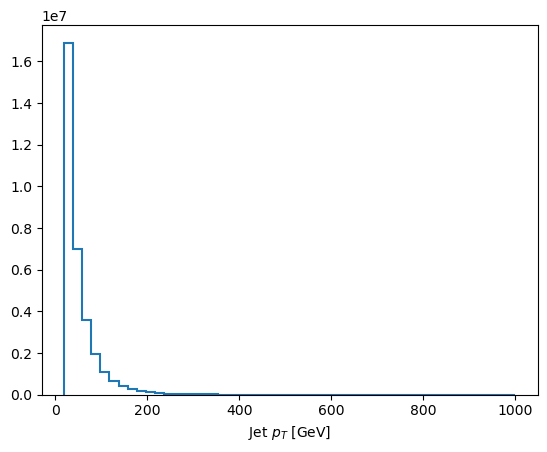

In [23]:
out.plot1d()

**Quiz 2:** 
* Define a processor class with the $Z$-peak analysis
    * Using a `Hist` object as output
    * Using a dictionary of Awkward arrays as output
* Run the processor using the `iterative_executor` or `futures_execyutor`
* Plot the histogram with the dimuon mass

**Using histograms as output**

In [24]:
import copy
from coffea import processor

class ZPeakProcessor(processor.ProcessorABC):
    
    def __init__(self):
        # define accumulator object 
        dimuon_mass_axis = hist.axis.Regular(
            bins=50, start=10, stop=150, name="dimuon_mass", label="$m(\mu, \mu)$ [GeV]"
        )
        self.output = hist.Hist(dimuon_mass_axis)
        
    
    def process(self, events):
        # create copies of histogram objects
        output = copy.deepcopy(self.output)
        
        # select good muons
        good_muons = (
            (events.Muon.pt >= 35)
            & (np.abs(events.Muon.eta) < 2.4)
            & (events.Muon.tightId)
            & (events.Muon.pfRelIso04_all < 0.15)
        )
        muons = events.Muon[good_muons]
        
        # we want events with two muons
        two_muons_cut = ak.num(muons) == 2

        # we want events with opposite charge muons
        opposite_charge_muons_cut = ak.sum(muons.charge, axis=1) == 0

        # select dimuons
        dimuons = muons[(two_muons_cut) & (opposite_charge_muons_cut)]

        # compute invariant mass
        dimuon_mass = (dimuons[:, 0] + dimuons[:, 1]).mass
        
        # fill output histogram
        output.fill(dimuon_mass=dimuon_mass)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [25]:
# define fileset (list of filenames in fileset must be a list or a dict)
fileset = {"dataset": [fname]}

# run a processor using the 'futures' executor
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=ZPeakProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": processor.NanoAODSchema, 
        "workers": 4
    }
)

Output()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fa968a22a00>, errorbar=None, legend_artist=None)]

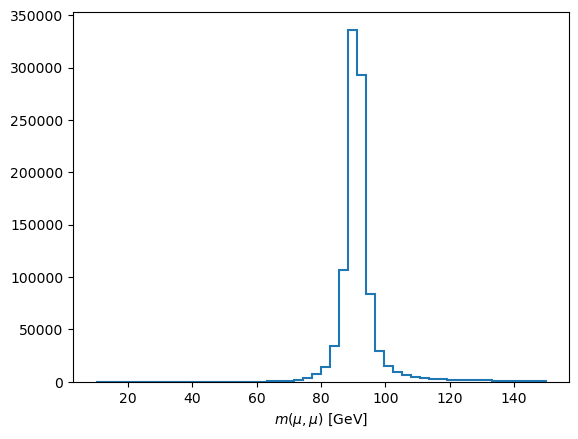

In [28]:
out.plot1d()

**Using a dictionary of awkward array as output**

In [33]:
class ZPeakProcessor(processor.ProcessorABC):
    def process(self, events):
        # select good muons
        good_muons = (
            (events.Muon.pt >= 35)
            & (np.abs(events.Muon.eta) < 2.4)
            & (events.Muon.tightId)
            & (events.Muon.pfRelIso04_all < 0.15)
        )
        muons = events.Muon[good_muons]

        # we want events with two muons
        two_muons_cut = ak.num(muons) == 2

        # we want events with opposite charge muons
        opposite_charge_muons_cut = ak.sum(muons.charge, axis=1) == 0

        # select dimuons
        dimuons = muons[(two_muons_cut) & (opposite_charge_muons_cut)]

        # compute invariant mass
        dimuon_mass = (dimuons[:, 0] + dimuons[:, 1]).mass

        # define output dictionary accumulator using a column accumulator
        # 'column_accumulator' only works with numpy arrays
        output = {"dimuon_mass": processor.column_accumulator(dimuon_mass.to_numpy())}

        return output

    def postprocess(self, accumulator):
        return accumulator

In [34]:
# define fileset (list of filenames in fileset must be a list or a dict)
fileset = {"dataset": [fname]}

# run a processor using the 'futures' executor
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=ZPeakProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": processor.NanoAODSchema, 
        "workers": 4
    }
)

Output()

In [35]:
out

{'dimuon_mass': column_accumulator(array([93.907875, 86.47147 , 91.16708 , ..., 95.20426 , 89.448135,
        89.72079 ], dtype=float32))}

In [36]:
out["dimuon_mass"].value

array([93.907875, 86.47147 , 91.16708 , ..., 95.20426 , 89.448135,
       89.72079 ], dtype=float32)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fa9689b8790>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

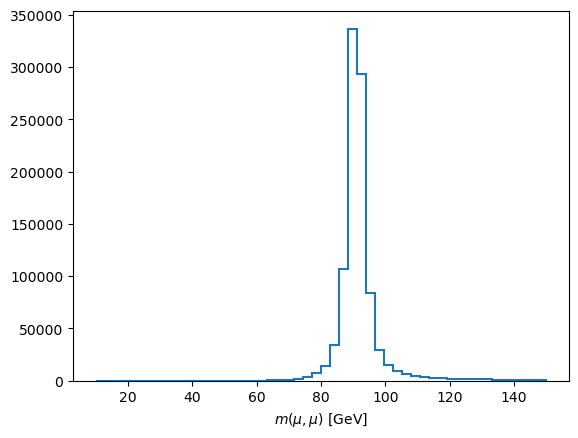

In [37]:
# define dimuon mass histogram
dimuon_mass_axis = hist.axis.Regular(
    bins=50, start=10, stop=150, name="dimuon_mass", label="$m(\mu, \mu)$ [GeV]"
)
dimuon_mass_hist = hist.Hist(dimuon_mass_axis)

dimuon_mass_hist.fill(out["dimuon_mass"].value)

dimuon_mass_hist.plot1d()

**Quiz 3:** 

* Modify the two previous processors such that, in addition to the dimuon transverse mass, kinematic variables of the leading and subleading muons are stored: transverse momentum $p_T$, pseudorapidity $\eta$ and azimuthal angle $\phi$.
* Plot the $p_T$, $\eta$ and $\phi$ histograms for leading and subleading muons.